<a href="https://colab.research.google.com/github/pragmalingu/experiments/blob/01_Stemming/Experiment/Algorithmic_Stemmer_Different_Filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Stemmer

Algorithmic stemmers apply a series of rules to each word to reduce it to its root form.

In this way, they present a few advantages:
1. They require little setup and usually work well out of the box;
2. They use little memory;
3. They are typically faster than dictionary stemmers.

(For more information see the [Elasticsearch documentation](https://www.elastic.co/guide/en/elasticsearch/reference/current/stemming.html#algorithmic-stemmers))

## Basic Demonstration

## Setup an Elasticsearch Instance in Google Colab

Everthing to connect to Elasticsearch, for detailed explaination see [this Notebook.](https://)
Download:

In [ ]:
import os
from subprocess import Popen, PIPE, STDOUT
# download elasticsearch
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.1-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.9.1-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.9.1

Start a local server:

In [ ]:
# start server
es_server = Popen(['elasticsearch-7.9.1/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
# client-side
!pip install elasticsearch -q
from elasticsearch import Elasticsearch
from datetime import datetime
es = Elasticsearch(["localhost:9200/"])
#wait a bit
import time
time.sleep(30)
es.ping()  # got True

True

### Analyser

An Analyser contains three lower-level building blocks: character filters, tokenizers, and token filters.
To apply stemming we first need to construct an analyser that makes use of the stemmer filter. 

(Stemmer filter reference guide at [Elasticsearch documentation](https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-stemmer-tokenfilter.html#analysis-stemmer-tokenfilter))

In [ ]:
#the order of filter and analyser is arbitrary

#stemmer token filter
stemmer_analyser = {
    "filter" : {
        "eng_stemmer" : {
        "type" : "stemmer",
        "name" : "english"
        }
    },
    "analyzer" : {
        "default" : {
            "tokenizer" : "standard",
            "filter" : ["lowercase", "eng_stemmer"]
        }
    }
}

#kstem token filter
kstem_analyser = {
    "filter" : {
        "eng_stemmer" : {
        "type" : "kstem",
        "name" : "english"
        }
    },
    "analyzer" : {
        "default" : {
            "tokenizer" : "standard",
            "filter" : ["lowercase", "eng_stemmer"]
        }
    }
}

#porter token filter
porter_analyser = {
    "filter" : {
        "eng_stemmer" : {
        "type" : "porter_stem",
        "name" : "english"
        }
    },
    "analyzer" : {
        "default" : {
            "tokenizer" : "standard",
            "filter" : ["lowercase", "eng_stemmer"]
        }
    }
}

#snowball token filter
snowball_analyser = {
    "filter" : {
        "eng_stemmer" : {
        "type" : "snowball",
        "name" : "english"
        }
    },
    "analyzer" : {
        "default" : {
            "tokenizer" : "standard",
            "filter" : ["lowercase", "eng_stemmer"]
        }
    }
}

### Indexing

The next step is to specify a default analyser for the index; in the following example we do so at index creation.

(Reference guide for analyser specification at [Elasticsearch documentation](https://www.elastic.co/guide/en/elasticsearch/reference/current/specify-analyzer.html#specify-index-time-default-analyzer))

In [ ]:
#create the correct settings
stemmer_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0,
        "analysis": stemmer_analyser
    }
}

kstem_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0,
        "analysis": kstem_analyser
    }
}

porter_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0,
        "analysis": porter_analyser
    }
}

snowball_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0,
        "analysis": snowball_analyser
    }
}

# create index

# stemmer token filter
es.indices.delete("stemmer-index")
es.indices.create("stemmer-index", body=stemmer_settings)

# kstem token filter
es.indices.delete("kstem-index")
es.indices.create("kstem-index", body=kstem_settings)

# porter token filter
es.indices.delete("porter-index")
es.indices.create("porter-index", body=porter_settings)

# snowball token filter
es.indices.delete("snowball-index")
es.indices.create("snowball-index", body=snowball_settings)

In [ ]:
#index document
doc = {
    'author': 'kimchy',
    'text': 'the foxes jumping quickly',
    'timestamp': datetime.now()
}

# stemmer token filter
res = es.index(index="stemmer-index", id=1, body=doc)
print(res['result'])

# kstem token filter
res = es.index(index="kstem-index", id=1, body=doc)
print(res['result'])

# porter token filter
res = es.index(index="porter-index", id=1, body=doc)
print(res['result'])

# snowball token filter
res = es.index(index="snowball-index", id=1, body=doc)
print(res['result'])

### Searching

Lastly, let us test stemming using a mock query. It's worthwhile to note that the example searches for `jump` rather than `jumping`; Elasticsearchs english stemmer removes the `-ing` suffix, preserving the words root form.

In [ ]:
#test query stemmer token filter
res = es.search(index="stemmer-index", body={"query": {"match" : {"text": {"query" : "jump"} }}})
print("Got %d Hits:" % res['hits']['total']['value'])
for hit in res['hits']['hits']:
    print("Stemmer: %(timestamp)s %(author)s: %(text)s\n" % hit["_source"])

#test query stemmer token filter
res = es.search(index="kstem-index", body={"query": {"match" : {"text": {"query" : "jump"} }}})
print("Got %d Hits:" % res['hits']['total']['value'])
for hit in res['hits']['hits']:
    print("Kstem: %(timestamp)s %(author)s: %(text)s\n" % hit["_source"])

#test query porter token filter
res = es.search(index="porter-index", body={"query": {"match" : {"text": {"query" : "jump"} }}})
print("Got %d Hits:" % res['hits']['total']['value'])
for hit in res['hits']['hits']:
    print("Porter: %(timestamp)s %(author)s: %(text)s\n" % hit["_source"])

#test query snowball token filter
res = es.search(index="snowball-index", body={"query": {"match" : {"text": {"query" : "jump"} }}})
print("Got %d Hits:" % res['hits']['total']['value'])
for hit in res['hits']['hits']:
    print("Snowball: %(timestamp)s %(author)s: %(text)s" % hit["_source"])

## Start Experimenting 

Get different corpora, format them and feed them to elasticsearch

### Cranfield Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cran/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/cranfield_corpus/CranfieldCorpus.ipynb) or for parsing in generel read [this guide](https://).

#### Data Processing

Get and process data:

In [ ]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
!tar -xf cran.tar.gz

# set paths to the dowloaded data as variables
PATH_TO_CRAN_TXT = '/content/cran.all.1400'
PATH_TO_CRAN_QRY = '/content/cran.qry'
PATH_TO_CRAN_REL = '/content/cranqrel'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

stemmer_cran_index = "stemmer-cranfield-corpus"
kstem_cran_index = "kstem-cranfield-corpus"
porter_cran_index = "porter-cranfield-corpus"
snowball_cran_index = "snowball-cranfield-corpus"

# get the text entries from the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cran_txt_list = get_data(PATH_TO_CRAN_TXT, ID_marker)
cran_qry_list = get_data(PATH_TO_CRAN_QRY, ID_marker)

# process text file

cran_chunk_start = re.compile('\.[A,B,T,W]')
cran_txt_data = defaultdict(dict)

for line in cran_txt_list:
  entries= re.split(cran_chunk_start,line)
  id = entries[0].strip()
  title = entries[1]
  author = entries[2]
  publication_date = entries[3]
  text = entries[4]
  cran_txt_data[id]['title'] = title
  cran_txt_data[id]['author'] = author
  cran_txt_data[id]['publication_date'] = publication_date
  cran_txt_data[id]['text'] = text

# process query file

qry_chunk_start = re.compile('\.W')
cran_qry_data = defaultdict(dict)

for n in range(0,len(cran_qry_list)-1):
  line = cran_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cran_qry_data[n+1]['question'] = question

# process relevance assesments

cran_rel_data = open(PATH_TO_CRAN_REL)
cran_np = np.loadtxt(cran_rel_data, dtype=int)

cran_rel = defaultdict(list)
for row in cran_np:
  cran_rel[row[0]].append(tuple(row[1:])) 

#### Index Cranfield corpus

Only needs to be done once, so if you're operating on our elastic search instance this one can be skipped:

In [ ]:
es.indices.delete(stemmer_cran_index)
es.indices.create(stemmer_cran_index, body=stemmer_settings)

es.indices.delete(kstem_cran_index)
es.indices.create(kstem_cran_index, body=kstem_settings)

es.indices.delete(porter_cran_index)
es.indices.create(porter_cran_index, body=porter_settings)

es.indices.delete(snowball_cran_index)
es.indices.create(snowball_cran_index, body=snowball_settings)

#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in cran_txt_data.items():
  es.index(index=stemmer_cran_index, id=ID, body=doc_data)
  es.index(index=kstem_cran_index, id=ID, body=doc_data)
  es.index(index=porter_cran_index, id=ID, body=doc_data)
  es.index(index=snowball_cran_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

### Medline Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/med/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/medline_corpus/MedlineCorpus.ipynb) or for parsing in generel read [this guide](https://).

#### Data Processing

Get and process data:

In [ ]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/medl/med.tar.gz
!tar -xf med.tar.gz

# set paths to the dowloaded data as variables
PATH_TO_MED_TXT = '/content/MED.ALL'
PATH_TO_MED_QRY = '/content/MED.QRY'
PATH_TO_MED_REL = '/content/MED.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

stemmer_med_index = "stemmer-medline-corpus"
kstem_med_index = "kstem-medline-corpus"
porter_med_index = "porter-medline-corpus"
snowball_med_index = "snowball-medline-corpus"

# get the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

med_txt_list = get_data(PATH_TO_MED_TXT, ID_marker)
med_qry_list = get_data(PATH_TO_MED_QRY, ID_marker)

# process the text and query files

qry_chunk_start = re.compile('\.W')

med_txt_data = defaultdict(dict)
med_qry_data = defaultdict(dict)

def fill_dictionary(dictionary, chunk_list, marker, key_name):
  for n in range(0,len(chunk_list)-1):
    line = chunk_list[n+1]
    _ , chunk = re.split(marker,line)
    dictionary[n+1][key_name] = chunk.strip()

fill_dictionary(med_txt_data, med_txt_list, qry_chunk_start, 'text')
fill_dictionary(med_qry_data, med_qry_list, qry_chunk_start, 'question')

# process relevance assesments with rating

med_rel_data = open(PATH_TO_MED_REL)
med_np = np.loadtxt(med_rel_data, dtype=int)

med_rel_rat = defaultdict(list)
for row in med_np:
  med_rel_rat[row[0]].append(row[2])

# process relevance assesments without rating
med_rel = defaultdict(list)

with open (PATH_TO_MED_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    med_rel[int(line[0])].append(line[2])

#### Index Medline corpus

Only needs to be done once, so if you're operating on our elastic search instance this one can be skipped:

In [ ]:
es.indices.delete(stemmer_med_index)
es.indices.create(stemmer_med_index, body=stemmer_settings)

es.indices.delete(kstem_med_index)
es.indices.create(kstem_med_index, body=kstem_settings)

es.indices.delete(porter_med_index)
es.indices.create(porter_med_index, body=porter_settings)

es.indices.delete(snowball_med_index)
es.indices.create(snowball_med_index, body=snowball_settings)

#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage

for ID, doc_data in med_txt_data.items():
  es.index(index=stemmer_med_index, id=ID, body=doc_data)
  es.index(index=kstem_med_index, id=ID, body=doc_data)
  es.index(index=porter_med_index, id=ID, body=doc_data)
  es.index(index=snowball_med_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

### ADI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/adi/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/adi_corpus/ADICorpus.ipynb) or for parsing in generel read [this guide](https://).

#### Data Processing

Download and parse data:

In [ ]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/adi/adi.tar.gz
!tar -xf adi.tar.gz

# set paths to the dowloaded data as variables
PATH_TO_ADI_TXT = '/content/ADI.ALL'
PATH_TO_ADI_QRY = '/content/ADI.QRY'
PATH_TO_ADI_REL = '/content/ADI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

stemmer_adi_index = "stemmer-adi-corpus"
kstem_adi_index = "kstem-adi-corpus"
porter_adi_index = "porter-adi-corpus"
snowball_adi_index = "snowball-adi-corpus"

# get the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

adi_txt_list = get_data(PATH_TO_ADI_TXT, ID_marker)
adi_qry_list = get_data(PATH_TO_ADI_QRY, ID_marker)

# process text file

adi_title_start = re.compile('\.T')
adi_author_start = re.compile('\.A')
adi_text_start = re.compile('\.W')

adi_txt_data = defaultdict(dict)

for line in adi_txt_list:
  entries = re.split(adi_title_start,line,1)
  id = entries[0].strip()
  no_id = entries[1]
  if len(re.split(adi_author_start, no_id,1)) > 1:
    no_id_entries = re.split(adi_author_start, no_id,1)
    adi_txt_data[id]['title'] = no_id_entries[0]
    no_title = no_id_entries[1]
    no_title_entries = re.split(adi_text_start, no_title)
    adi_txt_data[id]['author'] = no_title_entries[0]
    adi_txt_data[id]['text'] = no_title_entries[1]
  else:
    no_id_entries = re.split(adi_text_start, no_id)
    adi_txt_data[id]['title'] = no_id_entries[0]
    adi_txt_data[id]['text'] = no_id_entries[1]

# process query file    

qry_chunk_start = re.compile('\.W')
adi_qry_data = defaultdict(dict)

for n in range(0,len(adi_qry_list)-1):
  line = adi_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  adi_qry_data[n+1]['question'] = question

# process relevance assesment

adi_rel_data = open(PATH_TO_ADI_REL)
adi_np = np.loadtxt(adi_rel_data, dtype=float)

adi_rel = defaultdict(list)
for row in adi_np:
  adi_rel[int(row[0])].append(int(row[1])) 

#### Index ADI corpus

Only needs to be done once, so if you're operating on our elastic search instance this one can be skipped:

In [ ]:
es.indices.delete(stemmer_adi_index)
es.indices.create(stemmer_adi_index, body=stemmer_settings)

es.indices.delete(kstem_adi_index)
es.indices.create(kstem_adi_index, body=kstem_settings)

es.indices.delete(porter_adi_index)
es.indices.create(porter_adi_index, body=porter_settings)

es.indices.delete(snowball_adi_index)
es.indices.create(snowball_adi_index, body=snowball_settings)

#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage

for ID, doc_data in adi_txt_data.items():
  es.index(index=stemmer_adi_index, id=ID, body=doc_data)
  es.index(index=kstem_adi_index, id=ID, body=doc_data)
  es.index(index=porter_adi_index, id=ID, body=doc_data)
  es.index(index=snowball_adi_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

### CISI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/cisi_corpus/CISICorpus.ipynb) or for parsing in generel read [this guide](https://).

#### Data Processing

Download and parse data:

In [ ]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/cisi.tar.gz
!tar -xf cisi.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.
PATH_TO_CISI_TXT = '/content/CISI.ALL'
PATH_TO_CISI_QRY = '/content/CISI.QRY'
PATH_TO_CISI_REL = '/content/CISI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

stemmer_cisi_index = "stemmer-cisi-corpus"
kstem_cisi_index = "kstem-cisi-corpus"
porter_cisi_index = "porter-cisi-corpus"
snowball_cisi_index = "snowball-cisi-corpus"

# get the text and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cisi_txt_list = get_data(PATH_TO_CISI_TXT, ID_marker)
cisi_qry_list = get_data(PATH_TO_CISI_QRY, ID_marker)

# process text file

cisi_title_start = re.compile('[\n]\.T')
cisi_author_start = re.compile('[\n]\.A')
cisi_date_start = re.compile('[\n]\.B')
cisi_text_start = re.compile('[\n]\.W')
cisi_cross_start = re.compile('[\n]\.X')

cisi_txt_data = defaultdict(dict)

for line in cisi_txt_list:
  entries = re.split(cisi_title_start,line,1)
  id = entries[0].strip()#save the id
  no_id = entries[1] 
  
  if len(re.split(cisi_author_start, no_id)) >= 2: # is there just one author?
    no_id_entries = re.split(cisi_author_start, no_id,1)
    cisi_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    no_title = no_id_entries[1]

    if len(re.split(cisi_date_start, no_title)) > 1: # is there a publication date?
      no_title_entries = re.split(cisi_date_start, no_title)
      cisi_txt_data[id]['author'] = no_title_entries[0].strip() # save athour
      no_author = no_title_entries[1]
      no_author_entries = re.split(cisi_text_start, no_author)
      cisi_txt_data[id]['publication_date'] = no_author_entries[0].strip() # save publication date
      no_author_date = no_author_entries[1]
    else:
      no_title_entries = re.split(cisi_text_start, no_title)
      cisi_txt_data[id]['author'] = no_title_entries[0].strip() # save athour
      no_author_date = no_title_entries[1]

  else:
    no_id_entries = re.split(cisi_author_start, no_id)
    cisi_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    cisi_txt_data[id]['author'] = no_id_entries[1].strip() # save first author
    no_title_entries = re.split(cisi_text_start, no_title)
    cisi_txt_data[id]['author'] += ','+no_title_entries[0].strip() # save second athour
    no_author_date = no_title_entries[1]

  last_entries = re.split(cisi_cross_start, no_author_date)
  cisi_txt_data[id]['text'] = last_entries[0].strip() # save text
  cisi_txt_data[id]['cross-refrences'] = last_entries[1].strip() # save cross refrences

# process query file  

qry_chunk_start = re.compile('[\n]\.W')

cisi_qry_data = defaultdict(dict)

for line in cisi_qry_list:
  id , question = re.split(qry_chunk_start,line)
  id = re.findall('\d{1,3}',id)[0]
  cisi_qry_data[id]['question'] = question

# process the relevance assesment data
cisi_rel = defaultdict(list)

with open (PATH_TO_CISI_REL,'r') as f:
  for line in f:
    line = line.replace(' ','\t')
    line = re.split('\t',line)
    line = list(filter(None, line))
    cisi_rel[str(line[0])].append(str(line[1]))

#### Index CISI corpus

Only needs to be done once, so if you're operating on our elastic search instance this one can be skipped:

In [ ]:
es.indices.delete(stemmer_cisi_index)
es.indices.create(stemmer_cisi_index, body=stemmer_settings)

es.indices.delete(kstem_cisi_index)
es.indices.create(kstem_cisi_index, body=kstem_settings)

es.indices.delete(porter_cisi_index)
es.indices.create(porter_cisi_index, body=porter_settings)

es.indices.delete(snowball_cisi_index)
es.indices.create(snowball_cisi_index, body=snowball_settings)

#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage

for ID, doc_data in cisi_txt_data.items():
  es.index(index=stemmer_cisi_index, id=ID, body=doc_data)
  es.index(index=kstem_cisi_index, id=ID, body=doc_data)
  es.index(index=porter_cisi_index, id=ID, body=doc_data)
  es.index(index=snowball_cisi_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

### CACM Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

#### Data Processing

Download and parse data:

In [ ]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/cacm.tar.gz
!tar -xf cacm.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_CACM_TXT = '/content/cacm.all'
PATH_TO_CACM_QRY = '/content/query.text'
PATH_TO_CACM_REL = '/content/qrels.text'
PATH_TO_CACM_COMMON_WORDS = '/content/common_words'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

stemmer_cacm_index = "stemmer-cacm-corpus"
kstem_cacm_index = "kstem-cacm-corpus"
porter_cacm_index = "porter-cacm-corpus"
snowball_cacm_index = "snowball-cacm-corpus"

# get the text and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cacm_txt_list = get_data(PATH_TO_CACM_TXT, ID_marker)
cacm_qry_list = get_data(PATH_TO_CACM_QRY, ID_marker)

# process text file

cacm_chunk_title = re.compile('\.[T]\n')
cacm_chunk_txt = re.compile('\n\.W\n') # not enough
cacm_chunk_txt_pub = re.compile('\.[W,B]')
cacm_chunk_publication = re.compile('\.[B]\n')
cacm_chunk_author = re.compile('^\.[A]\n', re.MULTILINE)
cacm_chunk_author_add_cross = re.compile('^\.[A,N,X]\n',re.MULTILINE) # not enough
cacm_chunk_add_cross = re.compile('\.[B,N,X]\n')


cacm_txt_data = defaultdict(dict)

for line in cacm_txt_list:
  entries= re.split(cacm_chunk_title,line)
  id = entries[0].strip() #save id
  no_id = entries[1]

  if len(re.split(cacm_chunk_txt, no_id)) == 2: # is there text
    no_id_entries = re.split(cacm_chunk_txt_pub, no_id,1)
    cacm_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    cacm_txt_data[id]['text'] = no_id_entries[1].strip() # save text
    no_title_txt = no_id_entries[1]

    if len(re.split(cacm_chunk_author, no_title_txt)) == 2: # is there a auhtor
      no_title_entries = re.split(cacm_chunk_author_add_cross, no_title_txt)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['author'] = no_title_entries[1].strip() # save athor
      cacm_txt_data[id]['add_date'] = no_title_entries[2].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[3].strip() # save cross-references

    else:
      no_title_entries = re.split(cacm_chunk_publication, no_title_txt)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['add_date'] = no_title_entries[1].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[1].strip() # save cross-references

  else:
    no_id_entries = re.split(cacm_chunk_publication, no_id,1)
    cacm_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    no_title = no_id_entries[1]

    if len(re.split(cacm_chunk_author, no_title,1)) == 2: # is there a auhtor
      no_title_entries = re.split(cacm_chunk_author_add_cross, no_title)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['author'] = no_title_entries[1].strip() # save athor
      cacm_txt_data[id]['add_date'] = no_title_entries[2].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[3].strip() # save cross-references

    else:
      no_title_entries = re.split(cacm_chunk_add_cross, no_title)
      cacm_txt_data[id]['publication_date'] = no_title_entries[0].strip() # save publication date
      cacm_txt_data[id]['add_date'] = no_title_entries[1].strip() # save add date
      cacm_txt_data[id]['cross-references'] = no_title_entries[2].strip() # save cross-references

# process the query data

qry_chunk_start = re.compile('^\.W\n',re.MULTILINE)
cacm_qry_data = defaultdict(dict)

for n in range(0,len(cacm_qry_list)-1):
  line = cacm_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cacm_qry_data[n+1]['question'] = question

# process the relevance assesment data
cacm_rel = defaultdict(list)

with open (PATH_TO_CACM_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    cacm_rel[int(line[0])].append(line[1])

#### Index CACM corpus

Create an index for the CACM corpus. This is only possible if it isn't created yet.

(For more information see the [Elasticsearch documentation](https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create))

In [ ]:
#es.indices.delete(stemmer_cacm_index)
es.indices.create(stemmer_cacm_index, body=stemmer_settings)

#es.indices.delete(kstem_cacm_index)
es.indices.create(kstem_cacm_index, body=kstem_settings)

#es.indices.delete(porter_cacm_index)
es.indices.create(porter_cacm_index, body=porter_settings)

#es.indices.delete(snowball_cacm_index)
es.indices.create(snowball_cacm_index, body=snowball_settings)

#index document, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage

for ID, doc_data in cacm_txt_data.items():
  es.index(index=stemmer_cacm_index, id=ID, body=doc_data)
  es.index(index=kstem_cacm_index, id=ID, body=doc_data)
  es.index(index=porter_cacm_index, id=ID, body=doc_data)
  es.index(index=snowball_cacm_index, id=ID, body=doc_data)

create_response = es.cat.indices()
print(create_response)

## Evaluation

### Stemmer

In [ ]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

cran_index = 'stemmer-cranfield-corpus'
med_index = 'stemmer-medline-corpus'
adi_index = 'stemmer-adi-corpus'
cisi_index = 'stemmer-cisi-corpus'
cacm_index = 'stemmer-cacm-corpus'

# function to get normal match evaluation body 

def create_query_body_match(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
              "k" : 20,
              "relevant_rating_threshold": 1,
              "ignore_unlabeled": "false"
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "match": { "text": '' }}}
    current_query["query"]["match"]["text"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

# cranfield

cran_create_stemmer = create_query_body_match(cran_qry_data, cran_rel, cran_index)
cran_eval_body_stemmer = json.dumps(cran_create_stemmer)
cran_res_stemmer = es.rank_eval(cran_eval_body_stemmer, cran_index)
#print(json.dumps(cran_res, indent=4, sort_keys=True))

# medline

med_create_stemmer = create_query_body_match(med_qry_data, med_rel, med_index)
med_eval_body_stemmer = json.dumps(med_create_stemmer)
med_res_stemmer = es.rank_eval(med_eval_body_stemmer, med_index)
#print(json.dumps(med_res, indent=4, sort_keys=True))

# adi

adi_create_stemmer = create_query_body_match(adi_qry_data, adi_rel, adi_index)
adi_eval_body_stemmer = json.dumps(adi_create_stemmer)
adi_res_stemmer = es.rank_eval(adi_eval_body_stemmer, adi_index)
#print(json.dumps(adi_res, indent=4, sort_keys=True))

# cisi

cisi_create_stemmer = create_query_body_match(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_stemmer = json.dumps(cisi_create_stemmer)
cisi_res_stemmer = es.rank_eval(cisi_eval_body_stemmer, cisi_index)
#print(json.dumps(cisi_res, indent=4, sort_keys=True))

# cacm

cacm_create_stemmer = create_query_body_match(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_stemmer = json.dumps(cacm_create_stemmer)
cacm_res_stemmer = es.rank_eval(cacm_eval_body_stemmer, cacm_index)
#print(json.dumps(cacm_res, indent=4, sort_keys=True))

### Kstem

In [ ]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

cran_index = 'kstem-cranfield-corpus'
med_index = 'kstem-medline-corpus'
adi_index = 'kstem-adi-corpus'
cisi_index = 'kstem-cisi-corpus'
cacm_index = 'kstem-cacm-corpus'

# function to get normal match evaluation body 

def create_query_body_match(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
              "k" : 20,
              "relevant_rating_threshold": 1,
              "ignore_unlabeled": "false"
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "match": { "text": '' }}}
    current_query["query"]["match"]["text"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

# cranfield

cran_create_kstem = create_query_body_match(cran_qry_data, cran_rel, cran_index)
cran_eval_body_kstem = json.dumps(cran_create_kstem)
cran_res_kstem = es.rank_eval(cran_eval_body_kstem, cran_index)
#print(json.dumps(cran_res, indent=4, sort_keys=True))

# medline

med_create_kstem = create_query_body_match(med_qry_data, med_rel, med_index)
med_eval_body_kstem = json.dumps(med_create_kstem)
med_res_kstem = es.rank_eval(med_eval_body_kstem, med_index)
#print(json.dumps(med_res, indent=4, sort_keys=True))

# adi

adi_create_kstem = create_query_body_match(adi_qry_data, adi_rel, adi_index)
adi_eval_body_kstem = json.dumps(adi_create_kstem)
adi_res_kstem = es.rank_eval(adi_eval_body_kstem, adi_index)
#print(json.dumps(adi_res, indent=4, sort_keys=True))

# cisi

cisi_create_kstem = create_query_body_match(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_kstem = json.dumps(cisi_create_kstem)
cisi_res_kstem = es.rank_eval(cisi_eval_body_kstem, cisi_index)
#print(json.dumps(cisi_res, indent=4, sort_keys=True))

# cacm

cacm_create_kstem = create_query_body_match(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_kstem = json.dumps(cacm_create_kstem)
cacm_res_kstem = es.rank_eval(cacm_eval_body_kstem, cacm_index)
#print(json.dumps(cacm_res, indent=4, sort_keys=True))

### Porter

In [ ]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

cran_index = 'porter-cranfield-corpus'
med_index = 'porter-medline-corpus'
adi_index = 'porter-adi-corpus'
cisi_index = 'porter-cisi-corpus'
cacm_index = 'porter-cacm-corpus'

# function to get normal match evaluation body 

def create_query_body_match(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
              "k" : 20,
              "relevant_rating_threshold": 1,
              "ignore_unlabeled": "false"
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "match": { "text": '' }}}
    current_query["query"]["match"]["text"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

# cranfield

cran_create_porter = create_query_body_match(cran_qry_data, cran_rel, cran_index)
cran_eval_body_porter = json.dumps(cran_create_porter)
cran_res_porter = es.rank_eval(cran_eval_body_porter, cran_index)
#print(json.dumps(cran_res, indent=4, sort_keys=True))

# medline

med_create_porter = create_query_body_match(med_qry_data, med_rel, med_index)
med_eval_body_porter = json.dumps(med_create_porter)
med_res_porter = es.rank_eval(med_eval_body_porter, med_index)
#print(json.dumps(med_res, indent=4, sort_keys=True))

# adi

adi_create_porter = create_query_body_match(adi_qry_data, adi_rel, adi_index)
adi_eval_body_porter = json.dumps(adi_create_porter)
adi_res_porter = es.rank_eval(adi_eval_body_porter, adi_index)
#print(json.dumps(adi_res, indent=4, sort_keys=True))

# cisi

cisi_create_porter = create_query_body_match(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_porter = json.dumps(cisi_create_porter)
cisi_res_porter = es.rank_eval(cisi_eval_body_porter, cisi_index)
#print(json.dumps(cisi_res, indent=4, sort_keys=True))

# cacm

cacm_create_porter = create_query_body_match(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_porter = json.dumps(cacm_create_porter)
cacm_res_porter = es.rank_eval(cacm_eval_body_porter, cacm_index)
#print(json.dumps(cacm_res, indent=4, sort_keys=True))

### Snowball

In [ ]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

cran_index = 'snowball-cranfield-corpus'
med_index = 'snowball-medline-corpus'
adi_index = 'snowball-adi-corpus'
cisi_index = 'snowball-cisi-corpus'
cacm_index = 'snowball-cacm-corpus'

# function to get normal match evaluation body 

def create_query_body_match(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
              "k" : 20,
              "relevant_rating_threshold": 1,
              "ignore_unlabeled": "false"
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "match": { "text": '' }}}
    current_query["query"]["match"]["text"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

# cranfield

cran_create_snowball = create_query_body_match(cran_qry_data, cran_rel, cran_index)
cran_eval_body_snowball = json.dumps(cran_create_snowball)
cran_res_snowball = es.rank_eval(cran_eval_body_snowball, cran_index)
#print(json.dumps(cran_res, indent=4, sort_keys=True))

# medline

med_create_snowball = create_query_body_match(med_qry_data, med_rel, med_index)
med_eval_body_snowball = json.dumps(med_create_snowball)
med_res_snowball = es.rank_eval(med_eval_body_snowball, med_index)
#print(json.dumps(med_res, indent=4, sort_keys=True))

# adi

adi_create_snowball = create_query_body_match(adi_qry_data, adi_rel, adi_index)
adi_eval_body_snowball = json.dumps(adi_create_snowball)
adi_res_snowball = es.rank_eval(adi_eval_body_snowball, adi_index)
#print(json.dumps(adi_res, indent=4, sort_keys=True))

# cisi

cisi_create_snowball = create_query_body_match(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_snowball = json.dumps(cisi_create_snowball)
cisi_res_snowball = es.rank_eval(cisi_eval_body_snowball, cisi_index)
#print(json.dumps(cisi_res, indent=4, sort_keys=True))

# cacm

cacm_create_snowball = create_query_body_match(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_snowball = json.dumps(cacm_create_snowball)
cacm_res_snowball = es.rank_eval(cacm_eval_body_snowball, cacm_index)
#print(json.dumps(cacm_res, indent=4, sort_keys=True))

## Visualisation

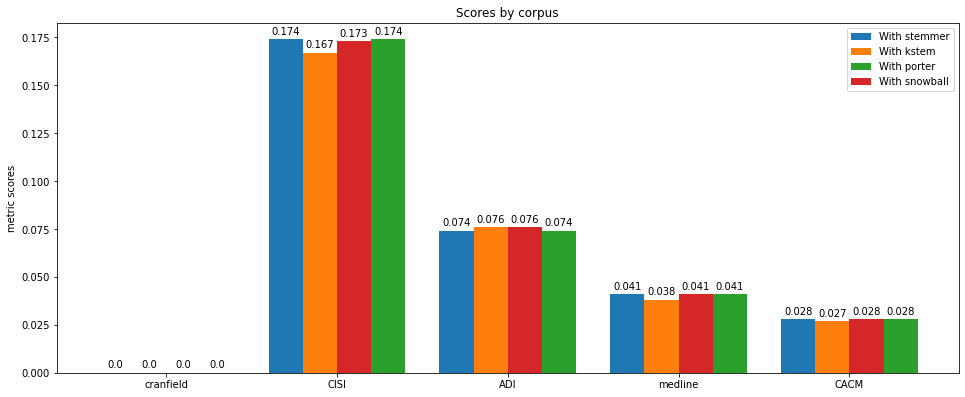

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

stemmer_metrics = []
stemmer_metrics.append(round(cran_res_stemmer['metric_score'], 3))
stemmer_metrics.append(round(cisi_res_stemmer['metric_score'], 3))
stemmer_metrics.append(round(adi_res_stemmer['metric_score'], 3))
stemmer_metrics.append(round(med_res_stemmer['metric_score'], 3))
stemmer_metrics.append(round(cacm_res_stemmer['metric_score'], 3))

kstem_metrics = []
kstem_metrics.append(round(cran_res_kstem['metric_score'], 3))
kstem_metrics.append(round(cisi_res_kstem['metric_score'], 3))
kstem_metrics.append(round(adi_res_kstem['metric_score'], 3))
kstem_metrics.append(round(med_res_kstem['metric_score'], 3))
kstem_metrics.append(round(cacm_res_kstem['metric_score'], 3))

porter_metrics = []
porter_metrics.append(round(cran_res_porter['metric_score'], 3))
porter_metrics.append(round(cisi_res_porter['metric_score'], 3))
porter_metrics.append(round(adi_res_porter['metric_score'], 3))
porter_metrics.append(round(med_res_porter['metric_score'], 3))
porter_metrics.append(round(cacm_res_porter['metric_score'], 3))

snowball_metrics = []
snowball_metrics.append(round(cran_res_snowball['metric_score'], 3))
snowball_metrics.append(round(cisi_res_snowball['metric_score'], 3))
snowball_metrics.append(round(adi_res_snowball['metric_score'], 3))
snowball_metrics.append(round(med_res_snowball['metric_score'], 3))
snowball_metrics.append(round(cacm_res_snowball['metric_score'], 3))

labels = ['cranfield', 'CISI', 'ADI', 'medline', 'CACM']

x = np.arange(len(labels))*2  # the label locations

width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*1.5, stemmer_metrics , width, label='With stemmer')
rects2 = ax.bar(x - width/2, kstem_metrics, width, label='With kstem')
rects3 = ax.bar(x + width*1.5, porter_metrics, width, label='With porter')
rects4 = ax.bar(x + width/2, snowball_metrics, width, label='With snowball')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
fig.set_figwidth(15)
fig.set_figheight(6)

plt.show()